# Setup

In [ ]:
!pip install sigtech

In [ ]:
import sigtech.api as sig
import os

os.environ["SIGTECH_API_KEY"] = ""

# Usage

In [ ]:
?sig.ReinvestmentStrategy

In [ ]:
?sig.RollingFutureStrategy

In [ ]:
?sig.BasketStrategy

In [ ]:
?sig.SignalStrategy

## Basic Example - Golden Crossover

In [ ]:
import datetime
import pandas as pd
import numpy as np

sig.init()

In [ ]:
g_cross = sig.RollingFutureStrategy(
    contract_code="ES",
    contract_sector="INDEX",
    currency="USD",
    start_date="2022-01-01",
)

g_cross.history()

In [ ]:
df = pd.DataFrame(g_cross.history().rename(g_cross.name)).dropna()

df["5d_sma"] = df[g_cross.name].rolling(5).mean().dropna()
df["15d_sma"] = df[g_cross.name].rolling(15).mean().dropna()
df.dropna(inplace=True)
df.tail(10)

In [ ]:
df["signal"] = np.where((df["5d_sma"] > df["15d_sma"]), 1, -1)
df.head(10)

In [ ]:
signal = sig.SignalStrategy(
    currency="USD",
    signal_input=df[["signal"]].rename(columns={"signal": g_cross.name}),
    start_date=df.first_valid_index().date(),
    rebalance_frequency="1W",
)

In [ ]:
signal.history().plot(figsize=(20, 10))

In [ ]:
signal.history().tail(10)

In [ ]:
import pyfolio as pf

%matplotlib inline

# silence warnings
import warnings

warnings.filterwarnings("ignore")

In [ ]:
g_cross_returns = signal.history().pct_change().dropna()

In [ ]:
# generate the performance report
pf.create_full_tear_sheet(g_cross_returns)

## Pairs Trading

In [94]:
# Corn
c = sig.RollingFutureStrategy(
    currency="USD",
    start_date=datetime.date(2020, 1, 1),
    contract_code="C",
    contract_sector="COMDTY",
    monthly_roll_days="5:9",
    rolling_rule="f_0",
)

# Rough Rice
rr = sig.RollingFutureStrategy(
    currency="USD",
    start_date=datetime.date(2020, 1, 1),
    contract_code="RR",
    contract_sector="COMDTY",
    monthly_roll_days="5:9",
    rolling_rule="f_0",
)

In [95]:
c_df = pd.DataFrame(c.history().rename(c.name)).dropna()
rr_df = pd.DataFrame(rr.history().rename(rr.name)).dropna()

In [96]:
c_df["5d_sma"] = c_df[c.name].rolling(5).mean().dropna()
rr_df["5d_sma"] = rr_df[rr.name].rolling(5).mean().dropna()

# create short and long signals where -1 is short and 1 is long and 0 is no position
c_df["short_signal"] = np.where((c_df["5d_sma"] > rr_df["5d_sma"] * 1.05), -1, 0)
c_df["long_signal"] = np.where((c_df["5d_sma"] < rr_df["5d_sma"] * 0.95), 1, 0)

rr_df["short_signal"] = np.where((c_df["5d_sma"] > rr_df["5d_sma"] * 1.05), 1, 0)
rr_df["long_signal"] = np.where((c_df["5d_sma"] < rr_df["5d_sma"] * 0.95), -1, 0)

c_df["signal"] = c_df["short_signal"] + c_df["long_signal"]
rr_df["signal"] = rr_df["short_signal"] + rr_df["long_signal"]

combined_df = pd.concat([c_df["signal"], rr_df["signal"]], axis=1)
combined_df.columns = [c.name, rr.name]
combined_df.head(30)

,USD C COMDTY LONG F_0 19382F09 RFS STRATEGY,USD RR COMDTY LONG F_0 2821B68A RFS STRATEGY
date,,
2020-01-02,0,0
2020-01-03,0,0
2020-01-06,0,0
2020-01-07,0,0
2020-01-08,0,0
2020-01-09,0,0
2020-01-10,0,0
2020-01-13,0,0
2020-01-14,0,0


<Axes: xlabel='date'>

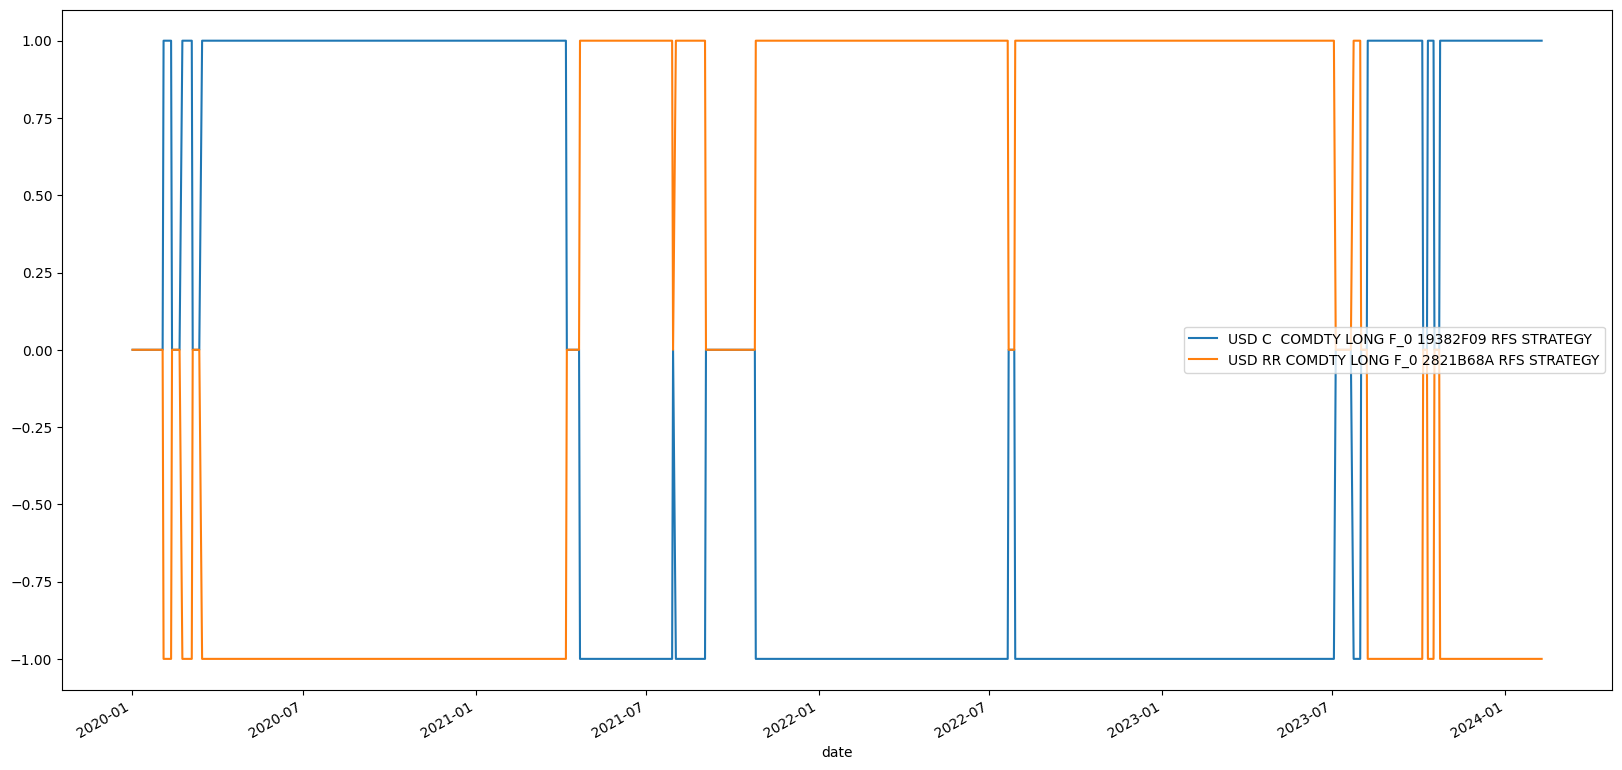

In [97]:
combined_df.plot(figsize=(20, 10))

In [100]:
combined_signal = sig.SignalStrategy(
    currency="USD",
    signal_input=combined_df,
    start_date=combined_df.first_valid_index().date(),
    rebalance_frequency="EOM",
)

<Axes: xlabel='date'>

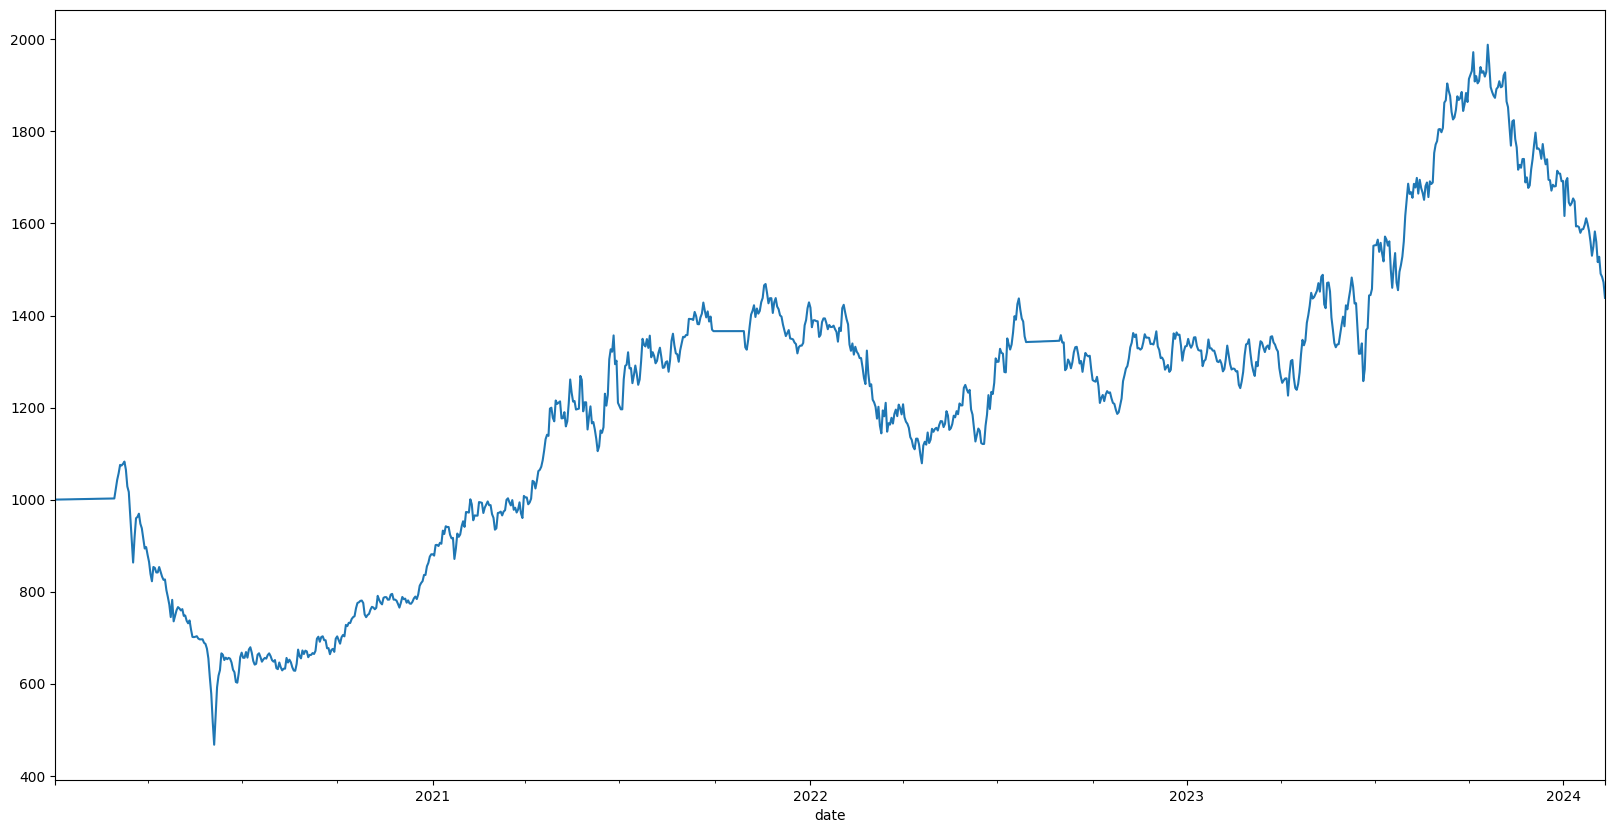

In [101]:
combined_signal.history().plot(figsize=(20, 10))

Start date,2020-01-03
End date,2024-02-09
Total months,51
,Backtest
Annual return,8.929%
Cumulative returns,43.834%
Annual volatility,30.04%
Sharpe ratio,0.43
Calmar ratio,0.16
Stability,0.71
Max drawdown,-56.824%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,56.82,2020-03-10,2020-06-04,2021-04-19,290
1,27.66,2023-10-19,2024-02-09,NaT,NaN
2,26.53,2021-11-19,2022-04-20,2023-05-09,383
3,15.52,2023-05-12,2023-06-21,2023-06-30,36
4,12.89,2021-05-25,2021-06-10,2021-06-22,21


Stress Events,mean,min,max
New Normal,0.05%,-10.48%,13.84%


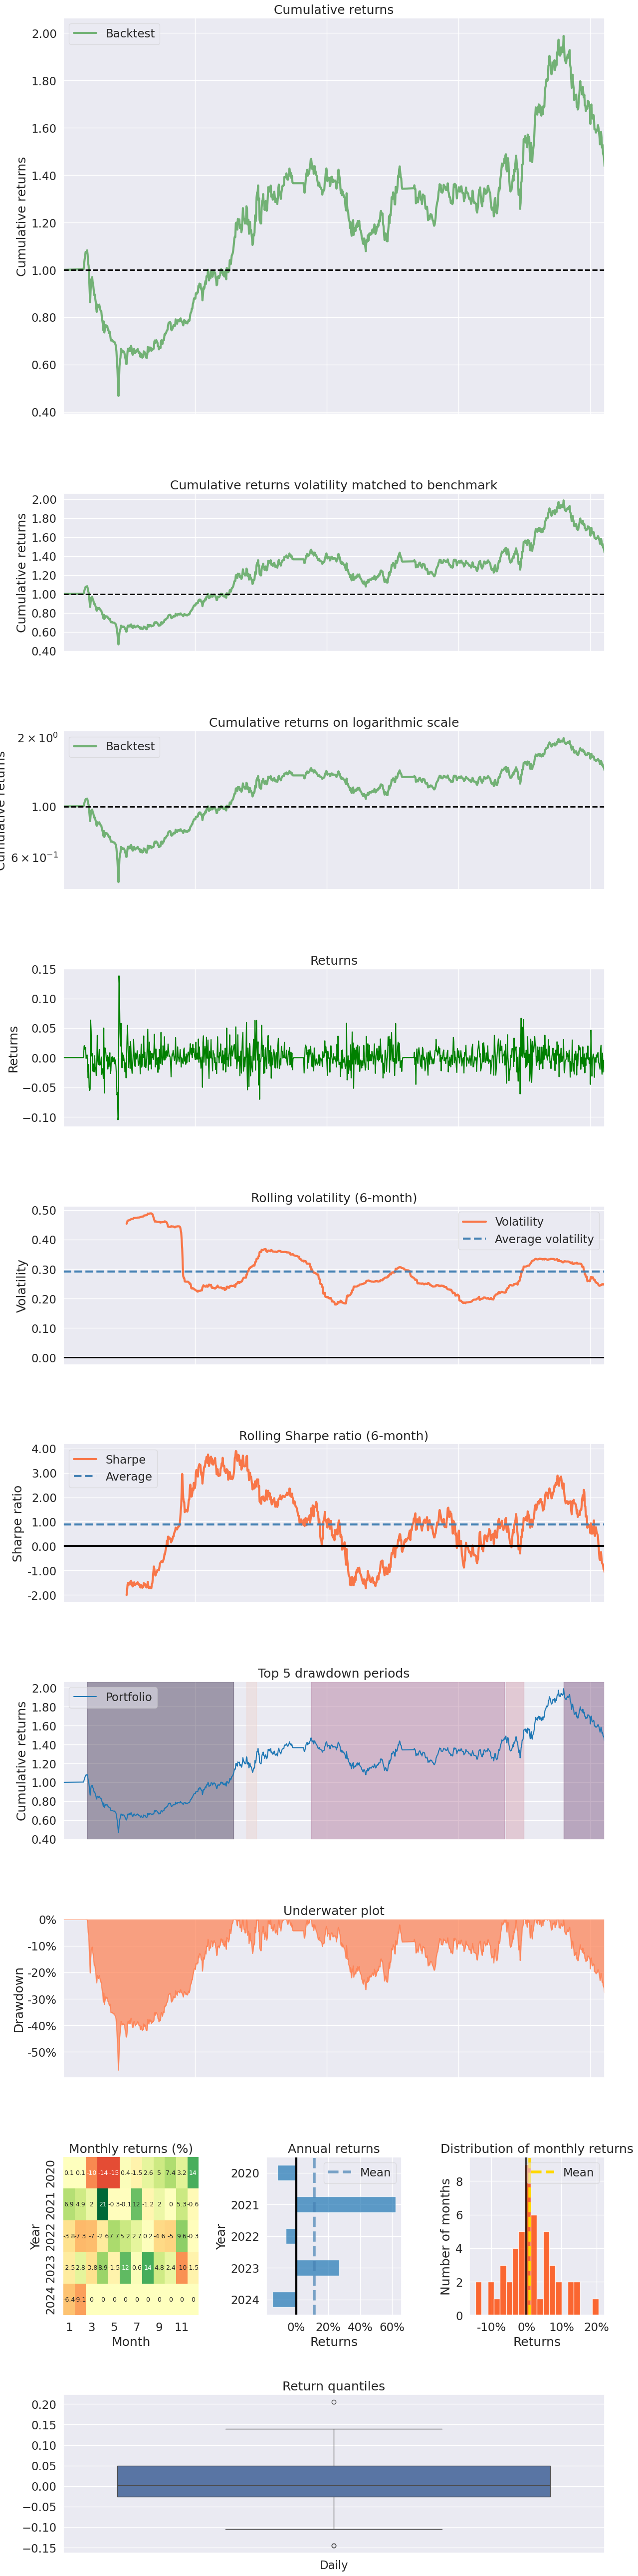

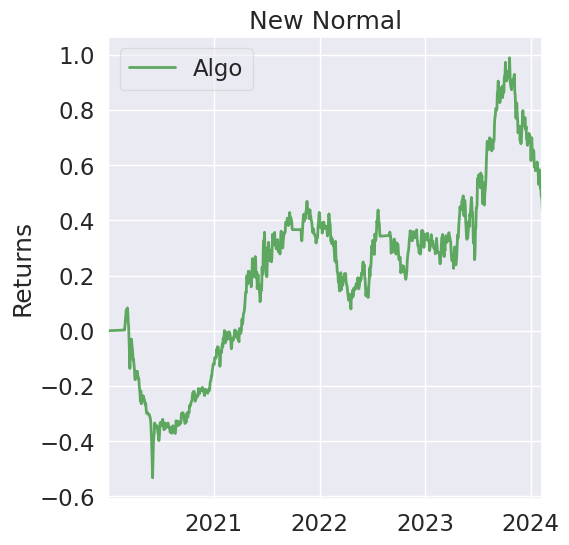

In [102]:
df_returns = combined_signal.history().pct_change().dropna()

pf.create_full_tear_sheet(df_returns)

In [108]:
combined_signal.plot.portfolio_table(
    dts="ACTION_PTS",
    unit_type="TRADE",
    flatten=True,
    as_df=True,
).head(10)

Execution Time  \
Date                 Name                     Level                         
2020/01/02, 07:30:00 USD 951E2094 SS STRATEGY 1                         -   
                     USD CASH                 2                         -   
2020/01/03, 07:30:00 USD 951E2094 SS STRATEGY 1                         -   
                     USD CASH                 2                         -   
2020/01/31, 07:30:00 USD 951E2094 SS STRATEGY 1                         -   
                     USD CASH                 2                         -   
2020/02/28, 07:30:00 USD 951E2094 SS STRATEGY 1                         -   
                     USD CASH                 2                         -   
                     C K20 COMDTY             2      2020/02/28, 19:15:00   
                     RRK20 COMDTY             2      2020/02/28, 22:30:00   

                                                     Weight Exp. Weight  \
Date                 Name                     Level                       
2020/01/02, 07:30:00 USD 951E2094 SS STRATEGY 1      100.0%           -   
                     USD CASH                 2      100.0%      100.0%   
2020/01/03, 07:30:00 USD 951E2094 SS STRATEGY 1      100.0%           -   
                     USD CASH                 2      100.0%      100.0%   
2020/01/31, 07:30:00 USD 951E2094 SS STRATEGY 1      100.0%           -   
                     USD CASH                 2      100.0%      100.0%   
2020/02/28, 07:30:00 USD 951E2094 SS STRATEGY 1      100.0%           -   
                     USD CASH                 2      100.0%      100.0%   
                     C K20 COMDTY             2        0.0%           -   
                     RRK20 COMDTY             2        0.0%           -   

                                                    Valuation     Units  \
Date                 Name                     Level                       
2020/01/02, 07:30:00 USD 951E2094 SS STRATEGY 1        1000.0       1.0   
                     USD CASH                 2        1000.0    1000.0   
2020/01/03, 07:30:00 USD 951E2094 SS STRATEGY 1      1000.043       1.0   
                     USD CASH                 2      1000.043  1000.043   
2020/01/31, 07:30:00 USD 951E2094 SS STRATEGY 1      1001.247       1.0   
                     USD CASH                 2      1001.247  1001.247   
2020/02/28, 07:30:00 USD 951E2094 SS STRATEGY 1      1002.483       1.0   
                     USD CASH                 2      1002.483  1002.483   
                     C K20 COMDTY             2           0.0     0.054   
                     RRK20 COMDTY             2           0.0    -0.036   

                                                    Value (USD) Value (local)  \
Date                 Name                     Level                             
2020/01/02, 07:30:00 USD 951E2094 SS STRATEGY 1          1000.0        1000.0   
                     USD CASH                 2             1.0           1.0   
2020/01/03, 07:30:00 USD 951E2094 SS STRATEGY 1        1000.043      1000.043   
                     USD CASH                 2             1.0           1.0   
2020/01/31, 07:30:00 USD 951E2094 SS STRATEGY 1        1001.247      1001.247   
                     USD CASH                 2             1.0           1.0   
2020/02/28, 07:30:00 USD 951E2094 SS STRATEGY 1        1002.483      1002.483   
                     USD CASH                 2             1.0           1.0   
                     C K20 COMDTY             2             0.0           0.0   
                     RRK20 COMDTY             2             0.0           0.0   

                                                    Position Type  
Date                 Name                     Level                
2020/01/02, 07:30:00 USD 951E2094 SS STRATEGY 1          Strategy  
                     USD CASH                 2              Cash  
2020/01/03, 07:30:00 USD 951E2094 SS STRATEGY 1          Strategy  
                   